In [27]:
#TODO Remove imports that aren't needed to save RAM
from tqdm import tqdm_notebook, tnrange
import tensorflow as tf

import pandas as pd
import numpy as np
from random import shuffle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os
import random
import itertools
from numba import prange

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [28]:
#!source ~/.bash_profile
#!export PATH="/usr/lib/google-cloud-sdk/bin:$PATH"

In [29]:
%run ../src/utils-bilinear.py
%run ../src/slope.py

In [30]:
import scipy.sparse as sparse
from scipy.sparse.linalg import splu

def speyediff(N, d, format = 'csc'):
    shape = (N-d, N)
    diagonals = np.zeros(2*d + 1)
    diagonals[d] = 1.
    for i in range(d):
        diff = diagonals[:-1] - diagonals[1:]
        diagonals = diff
    offsets = np.arange(d+1)
    spmat = sparse.diags(diagonals, offsets, shape, format = format)
    return spmat

def smooth(y, lmbd, d = 2):
    m = len(y)
    E = sparse.eye(m, format = 'csc')
    D = speyediff(m, d, format = 'csc')
    coefmat = E + lmbd * D.conj().T.dot(D)
    z = splu(coefmat).solve(y)
    return np.stack(z)

def reconstruct_images(plot_id):
    subs = df[df['PLOT_ID'] == plot_id]
    rows = []
    lats = reversed(sorted(subs['LAT'].unique()))
    for i, val in enumerate(lats):
        subs_lat = subs[subs['LAT'] == val]
        subs_lat = subs_lat.sort_values('LON', axis = 0)
        rows.append(list(subs_lat['TREE']))
    return rows

def check_outliers(sample):
    for date in range(22):
        for band in range(10):
            maxs = np.max(sample[date, :, :, band])
            mins = np.min(sample[date, :, :, band])
            if maxs == 1.0 or mins == 0.0:
                print("Found null outlier")
                return True
            if maxs == mins:
                print("Found missing outlier")
                return True
            if maxs >= 1.05 or mins <= -1.05:
                print("Found range outlier")
                return True
    else:
        return False

In [31]:
source = 'train'
sentinel_1 = True

In [32]:
if source == 'train':
    folder = '../data/train-super/'
    dfs = []
    for i in os.listdir("../data/train-csv/"):
        if ".DS" not in i:
            print(i)
            df = pd.read_csv("../data/train-csv/" + i).drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)
            df['country'] = i.split("-")[0]
            dfs.append(df)
            
    df = pd.concat(dfs, ignore_index = True)
    df = df.dropna(axis = 0)

    existing = [int(x[:-4]) for x in os.listdir(folder) if ".DS" not in x]
    df = df[df['PLOT_ID'].isin(existing)]
    plot_ids = sorted(df['PLOT_ID'].unique())
    
    
if source == 'finetune':
    folder = '../data/train-super/'
    dfs = []
    for i in os.listdir("../data/train-csv/"):
        if ".DS" not in i:
            # Africa
            #if any(x in i for x in ["africa-east", "subplot", "kenya", "malawi", "sudan",
            #                       "africa-west", "ghana", "koure", "niger"]):
            # East Africa
            #if any(x in i for x in ["africa-east", "subplot", "kenya", "malawi", "sudan"]):
            # West Africa
            if any(x in i for x in ["africa-west", "cameroon", "koure", "niger", "ghana-farm"]):
            # South america
            #if any(x in i for x in ["brazil", "sa-"]):
            # LAC
            #India
            #if "india" in i:
            #if any(x in i for x in ["brazil", "mexico", "elsalvador", "sa-", "lac"]):
                print(i)
                df = pd.read_csv("../data/train-csv/" + i).drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)
                df['country'] = i.split("-")[0]
                dfs.append(df)
            
    df = pd.concat(dfs, ignore_index = True)
    df = df.dropna(axis = 0)

    existing = [int(x[:-4]) for x in os.listdir(folder) if ".DS" not in x]
    df = df[df['PLOT_ID'].isin(existing)]

    plot_ids = sorted(df['PLOT_ID'].unique())
    source = 'train'

if source == 'test':
    folder = "../data/test-super/"
    dfs = []
    for i in os.listdir("../data/test-csv/"):
        if ".DS" not in i and i != "africa-east-test.csv":
            print(i)
            df = pd.read_csv("../data/test-csv/" + i).drop('IMAGERY_TITLE', axis = 1).dropna(axis = 0)
            df['country'] = i.split("-")[0]
            dfs.append(df)
    if len(dfs) > 1:
        df = pd.concat(dfs, ignore_index = True)
    #df = df.drop('IMAGERY_TITLE', axis = 1)
    df = df.dropna(axis = 0)
    
    existing = [int(x[:-4]) for x in os.listdir(folder) if ".DS" not in x]
    df = df[df['PLOT_ID'].isin(existing)]
    N_SAMPLES = int(df.shape[0]/196)

    plot_ids = sorted(df['PLOT_ID'].unique())

#source = 'test'#

ghana-kwofu-train.csv
kenya-makueni-train.csv
cameroon-finetune-3.csv
cameroon-finetune-2.csv
koure-finetune.csv
india-sidh-train.csv
ghana-ashanti-train-2.csv
africa-east-train.csv
mexico-campeche-train.csv
ghana-farm-train.csv
sa-train.csv
ghana-south-train.csv
cameroonnigerghana-train.csv
brazil-paraiba-train.csv
malawi-rumphi-train.csv
ghana-ashanti-train-small.csv
ghana-train.csv
kenya-train.csv
india-train.csv
malawi-rumphi-small.csv
rwanda-train.csv
cameroon-train.csv
subplot4.csv
kenya-farm-train-2.csv
elsalvador-train.csv
india-kochi-train.csv
subplot.csv
sudan-train.csv
niger-train.csv
subplot2.csv
subplot3.csv
ghana-ashanti-train.csv
ghana-upperwest-train.csv
malawi-train.csv
africa-west-train.csv
ghana-kwofu-large.csv
lac-train.csv
ghana-mid-train.csv
ghana-kwofu-small-train.csv
cameroon-finetune.csv
kenya-farm-train.csv
koure-train.csv


In [33]:
existing = [int(x[:-4]) for x in os.listdir("../data/{}-super".format(source)) if ".DS_S" not in x]
df = df[df['PLOT_ID'].isin(existing)]

In [34]:
# Initiate empty lists to store the X and Y data in
data_x, data_y, lengths = [], [], []
    
    
countries = {}
count = 0
# Iterate over each plot
for i in tnrange(len(plot_ids)):
    skip = True if sentinel_1 else False
    # Removed plot ids are either ambiguous labels, or imagery issues
    if plot_ids[i] not in [135191206, 135191281, 135346016, 135787924, 135345883, 135680141]:
        # Load the sentinel imagery
        if (str(plot_ids[i]) + ".npy")in os.listdir("../data/{}-super".format(source)):
            country = df[df['PLOT_ID'] == plot_ids[i]]['country'].unique()
            if str(country[0]) not in countries.keys():
                countries[str(country[0])] = [count, count]
            countries[str(country[0])][1] = count
            x = np.load("../data/{}-super/".format(source) + str(plot_ids[i]) + ".npy")
            if sentinel_1 and os.path.isfile("../tile_data/{}-s1/{}.npy".format(source, str(plot_ids[i]))):
                skip = False
                s1 = np.load("../tile_data/{}-s1/{}.npy".format(source, str(plot_ids[i])))
                x = np.concatenate([x, s1], axis = -1)
            count += 1
        y = reconstruct_images(plot_ids[i])
        if not skip:
            lengths.append(x.shape[0])
            data_x.append(x)
            data_y.append(y)
print("Finished data loading")

data_x = np.stack(data_x)
data_y = np.stack(data_y)
lengths = np.stack(lengths)


Finished data loading


In [35]:
print(data_x.shape)

(3172, 24, 16, 16, 17)


In [36]:
print(countries)

{'subplot.csv': [0, 197], 'subplot2.csv': [198, 333], 'subplot3.csv': [334, 495], 'subplot4.csv': [496, 684], 'rwanda': [685, 712], 'kenya': [713, 2407], 'niger': [816, 938], 'sudan': [939, 961], 'koure': [962, 3131], 'malawi': [992, 2376], 'ghana': [1034, 2174], 'brazil': [1733, 1808], 'mexico': [1809, 1897], 'elsalvador': [1898, 1970], 'india': [2408, 2692], 'sa': [2435, 2468], 'lac': [2469, 2522], 'africa': [2693, 2904], 'cameroonnigerghana': [2905, 2992], 'cameroon': [2993, 3172]}


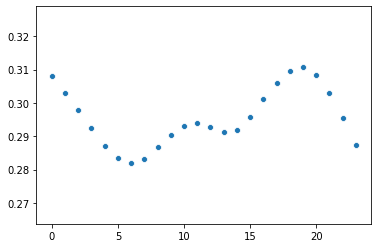

In [37]:
ys = np.mean(data_x[22, :, :, :, 3], (1, 2))
#ys = data_x[52, :, 1, 12, 3]
xs = np.array([x for x in range(24)])
sns.scatterplot(y = ys, x = xs)

In [38]:
def mask_segments(arr, percent):
    masked = np.copy(arr)
    for sample in range(masked.shape[0]):
        start = random.sample(range(72 - int(72*(percent))), 1)[0]
        length = int(72*(percent))
        
        masked[sample, start:start+length] = np.tile(
            (masked[sample, start] + masked[sample, start+length])/2,
            (1, length, 1, 1, 1))
        
    return masked

def apply_smoothing(arr, lmb):
    smoothed = np.copy(arr)
    for sample in tnrange(smoothed.shape[0]):
        for row in range(0, 16):
            for column in range(0, 16):
                for band in [x for x in range(0, 15) if x != 10]:
                    sm = smooth(smoothed[sample, :, row, column, band], lmb, d = 2)
                    smoothed[sample, :, row, column, band] = sm
    return smoothed

#for lmb in [1, 20, 50, 100, 500, 750]:
#    for percent in [20, 30, 40, 50]:
#        masked = mask_segments(data_x, percent/100)
#        smoothed = apply_smoothing(masked, lmb)
#        mse = np.mean(abs(smoothed - data_x))
#        #mse = calculate_mse(smoothed, data_x)
#        print("{}% masked data, {} lambda: {} error".format(percent, lmb, mse))

In [39]:
#source = 'test'
if source == 'train':
    np.save("../tile_data/processed/data_x_l2a_processed.npy", data_x)
    np.save("../tile_data/processed/data_y_l2a_processed.npy", data_y)
    np.save("../tile_data/processed/length_l2a_processed.npy", lengths)
if source == 'test':
    print("Writing test data")
    np.save("../tile_data/processed/test_x_l2a_processed.npy", data_x)
    np.save("../tile_data/processed/test_y_l2a_processed.npy", data_y)
    np.save("../tile_data/processed/test_length_l2a_processed.npy", lengths)

In [40]:
lats = []
longs = []
for i in plot_ids:
    subs = df[df['PLOT_ID'] == i]
   # print(subs['LAT'])
    lats.append(float(subs['LAT'].head(1)))
    longs.append(float(subs['LON'].head(1)))
    
lats = np.array(lats)
longs = np.array(longs)
    
BBox = ((longs.min(),   longs.max(),      
         lats.min(), lats.max()))

print(BBox)

(-100.9472446047355, 82.42577232083404, -22.804542414728047, 24.81825834355684)


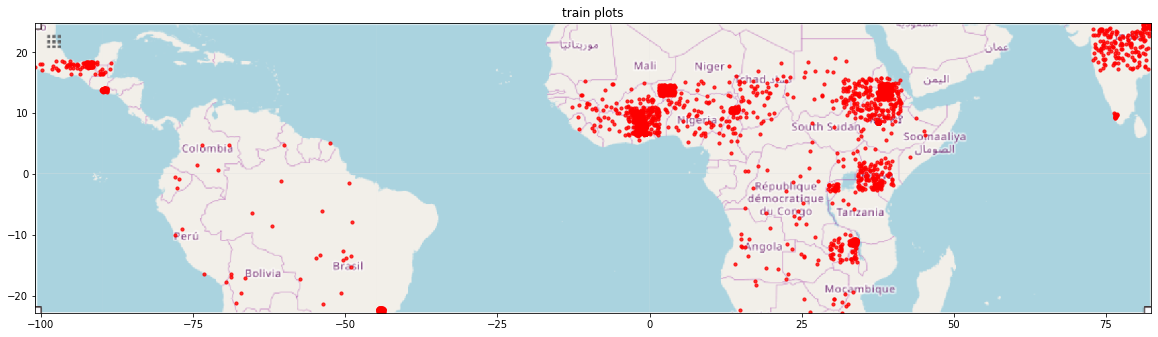

In [42]:
area = plt.imread('../references/{}-area.png'.format('train'))

fig, ax = plt.subplots(figsize = (20,10))
ax.scatter(longs, lats, zorder=1, alpha= 0.8, c='r', s=10)
ax.set_title('{} plots'.format(source))
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(area, zorder=0, extent = BBox, aspect= 'equal')
plt.savefig('../references/{}-plots.png'.format("train"), dpi = 300)

# Compare  superresolved and bicubic

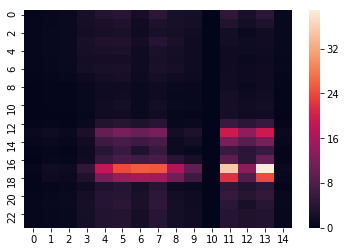

In [667]:
smp = -65
sns.heatmap(np.sum(abs(validated[smp, :24, :, :] - orig[smp, :24, :, :]), axis = (1, 2)))